In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

df = pd.read_csv(r"C:\Users\shris\Downloads\mock_apple_stock_data.csv")

In [2]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
print(df.head())

        Date    Open    High     Low   Close   Volume
0 2022-01-03  151.09  151.37  149.32  150.82  1176615
1 2022-01-04  150.49  151.35  149.04  151.35  1187628
2 2022-01-05  151.71  152.16  149.68  151.68  3735988
3 2022-01-06  152.28  153.41  151.73  152.76  3470784
4 2022-01-07  151.37  153.40  150.77  152.01  4280143


In [3]:
#Features
df['Daily_Return'] = df['Close'] - df['Open'] # The gain or loss between Open and Close prices
df['Return_Pct'] = ((df['Close'] - df['Open']) / df['Open']) * 100 # Percentage change from Open to Close
df['Daily_Range'] = df['High'] - df['Low'] # Daily Range - Intraday price spead
df['Volatility'] = (df['High'] - df['Low']) / df['Close'] #Volatility - Relative daily range compared to Close
df['MA_3'] = df['Close'].rolling(window=3).mean() # Moving averages - Smoothed avergae of past Close prices
df['MA_7'] = df['Close'].rolling(window=7).mean()  
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['Momentum_3'] = df['Close'] - df['Close'].shift(3) # Momentum - Change in Close price over past 3 days
df['Prev_Close'] = df['Close'].shift(1) # Previous Closing price
df['Next_Close'] = df['Close'].shift(-1) # Next days Close (Target)

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Daily_Return,Return_Pct,Daily_Range,Volatility,MA_3,MA_7,MA_14,Momentum_3,Prev_Close,Next_Close
0,2022-01-03,151.09,151.37,149.32,150.82,1176615,-0.27,-0.178701,2.05,0.013592,NaN,NaN,NaN,NaN,NaN,151.35
1,2022-01-04,150.49,151.35,149.04,151.35,1187628,0.86,0.571467,2.31,0.015263,NaN,NaN,NaN,NaN,150.82,151.68
2,2022-01-05,151.71,152.16,149.68,151.68,3735988,-0.03,-0.019775,2.48,0.016350,151.283333,NaN,NaN,NaN,151.35,152.76
3,2022-01-06,152.28,153.41,151.73,152.76,3470784,0.48,0.315209,1.68,0.010998,151.930000,NaN,NaN,1.94,151.68,152.01
4,2022-01-07,151.37,153.40,150.77,152.01,4280143,0.64,0.422805,2.63,0.017301,152.150000,NaN,NaN,0.66,152.76,152.05


In [5]:
df = df.dropna().reset_index(drop=True)

In [6]:
df.head()

,Date,Open,High,Low,Close,Volume,Daily_Return,Return_Pct,Daily_Range,Volatility,MA_3,MA_7,MA_14,Momentum_3,Prev_Close,Next_Close
0,2022-01-20,152.16,153.10,150.10,152.41,4612610,0.25,0.164301,3.00,0.019684,153.350000,153.891429,152.960000,-1.46,153.01,150.99
1,2022-01-21,149.28,150.78,148.54,150.99,3837579,1.71,1.145498,2.24,0.014835,152.136667,153.490000,152.972143,-3.64,152.41,149.49
2,2022-01-24,149.53,150.89,148.48,149.49,3609305,-0.04,-0.026750,2.41,0.016121,150.963333,152.808571,152.839286,-3.52,150.99,148.49
3,2022-01-25,147.96,149.73,146.68,148.49,3164367,0.53,0.358205,3.05,0.020540,149.656667,151.841429,152.611429,-3.92,149.49,149.42
4,2022-01-26,148.97,150.60,146.91,149.42,2904050,0.45,0.302074,3.69,0.024695,149.133333,151.205714,152.372857,-1.57,148.49,148.24


In [7]:
df.describe()

,Date,Open,High,Low,Close,Volume,Daily_Return,Return_Pct,Daily_Range,Volatility,MA_3,MA_7,MA_14,Momentum_3,Prev_Close,Next_Close
count,236,236.000000,236.000000,236.000000,236.000000,2.360000e+02,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000
mean,2022-07-03 21:33:33.559322112,142.883729,144.068602,141.534322,142.869788,2.938057e+06,-0.013941,-0.008853,2.534280,0.017738,142.890946,142.943293,143.006341,-0.071992,142.884195,142.856568
min,2022-01-20 00:00:00,136.390000,137.690000,134.710000,136.040000,1.003267e+06,-2.080000,-1.476748,1.120000,0.007949,136.473333,137.347143,137.821429,-4.570000,136.040000,136.040000
25%,2022-04-12 18:00:00,139.572500,140.807500,138.367500,139.615000,1.862238e+06,-0.502500,-0.349965,2.130000,0.014839,139.536667,139.587857,139.665179,-1.392500,139.615000,139.615000
50%,2022-07-04 12:00:00,141.695000,142.830000,140.470000,141.665000,3.004680e+06,0.020000,0.013687,2.495000,0.017875,141.656667,141.627857,141.262143,-0.110000,141.665000,141.665000
75%,2022-09-23 18:00:00,145.767500,146.700000,144.100000,145.852500,3.965872e+06,0.505000,0.353602,2.982500,0.020784,145.709167,145.508571,145.439464,1.112500,145.852500,145.852500
max,2022-12-15 00:00:00,152.800000,153.510000,151.430000,152.600000,4.989618e+06,1.710000,1.198497,3.740000,0.025777,153.350000,153.891429,152.972143,5.910000,153.010000,152.600000
std,NaN,4.160783,4.153668,4.086802,4.177950,1.198849e+06,0.714992,0.501199,0.600143,0.004163,4.137023,4.158296,4.158427,1.872399,4.207052,4.152492


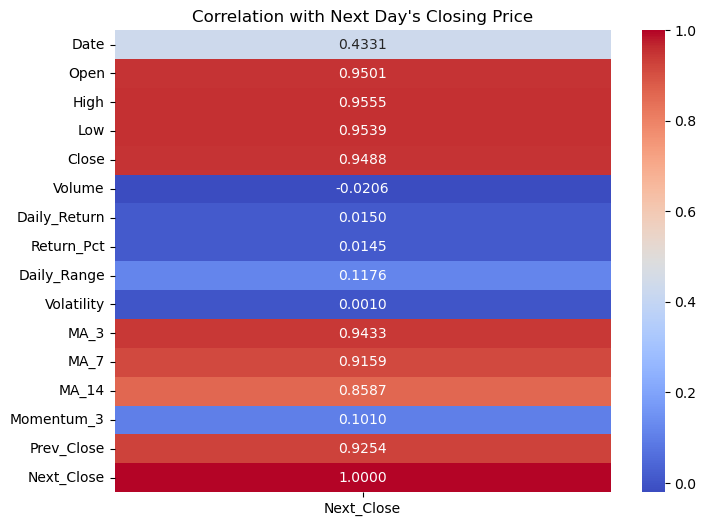

In [8]:
correlation_matrix = df.corr()
#Select only the correlations with 'Next_Close'
correlation_with_target = correlation_matrix[['Next_Close']]
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_target, annot=True, cmap="coolwarm", fmt=".4f", cbar=True)
plt.title("Correlation with Next Day's Closing Price")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

In [9]:
# Based off of this heat map we can assume that Lag features and trend features are very predicitve.
# Prev_Close, MA_3, MA_7, Open, Close, High, Low — all have high correlations with Next_Close.
# Volume and volatility features are weak for direct prediction of closing price.
# The shorter term moving averages such as MA_3 and MA_7 tend to be more predicitve than MA_14.
# Based off of the correlations that are seen here its best to tackle the following features: ['Open', 'High', 'Low', 'Close', 'Prev_Close', 'MA_3', 'MA_7'] 

In [10]:
top_features = ['Open', 'High', 'Low', 'Close', 'Prev_Close', 'MA_3', 'MA_7']

In [11]:
df[top_features].isnull().sum()

Open          0
High          0
Low           0
Close         0
Prev_Close    0
MA_3          0
MA_7          0
dtype: int64

In [12]:
target = 'Next_Close'

In [13]:
X = df[top_features]
y = df[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # optional for RandomForest, but good for pipeline reuse
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [16]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 2.08
R² Score: 0.29


C:\Users\shris\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


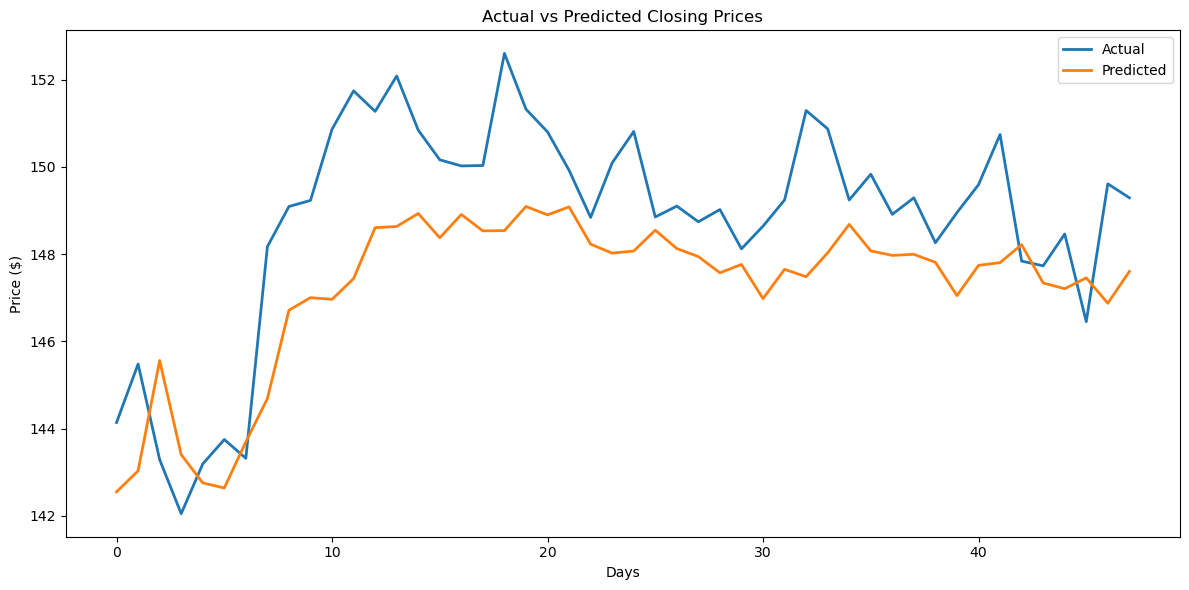

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Closing Prices")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# The data is off by 2 dollars, so we need to tune the model in order to get it as close to the actual data as possible.

C:\Users\shris\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Best Parameters: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
RMSE: 1.94
R² Score: 0.38


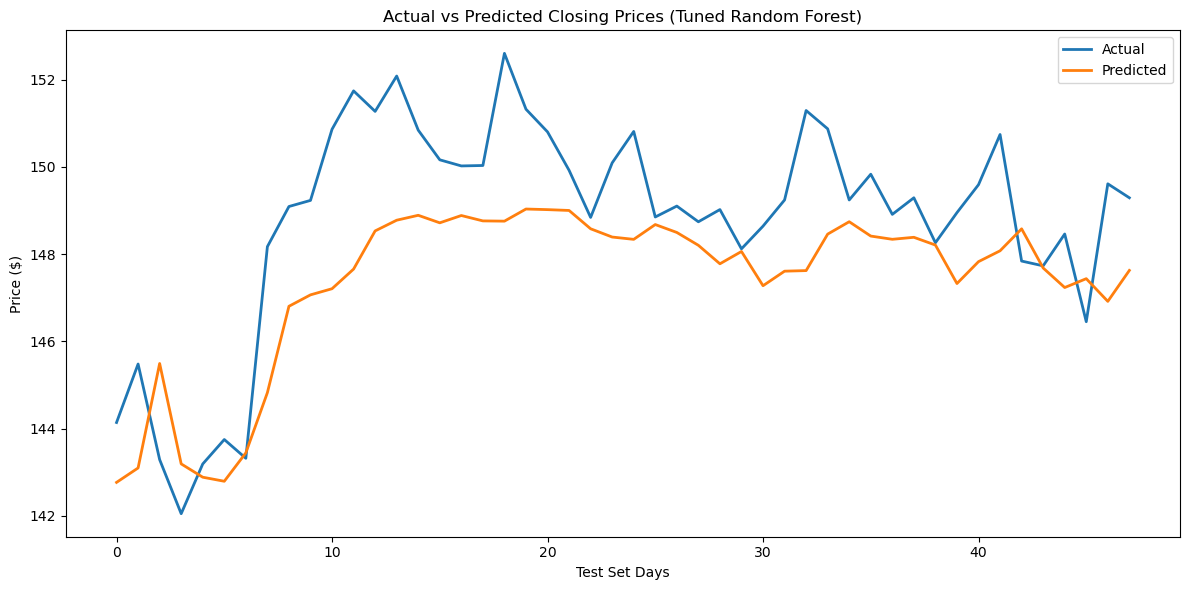

In [19]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("RMSE:", round(rmse, 2))
print("R² Score:", round(r2, 2))

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Closing Prices (Tuned Random Forest)")
plt.xlabel("Test Set Days")
plt.ylabel("Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
# Lets improve the features in order to make this model more accurate
# Add features:
# Lag_2 & Lag_3 --> Gives the model memory of 2-3 days ago prices
# Return_Pct --> Normalized return
# Adding more signals about past price behaviour gives XGBoost more room to learn patterns.

In [42]:
df['Lag_2'] = df['Close'].shift(2)
df['Lag_3'] = df['Close'].shift(3)
df['Return_Pct'] = ((df['Close'] - df['Open']) / df['Open']) * 100

In [44]:
top_features = ['Open', 'High', 'Low', 'Close', 'Prev_Close', 'MA_3', 'MA_7', 'Lag_2', 'Lag_3']

C:\Users\shris\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Best Params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
RMSE: 1.94
R² Score: 0.38


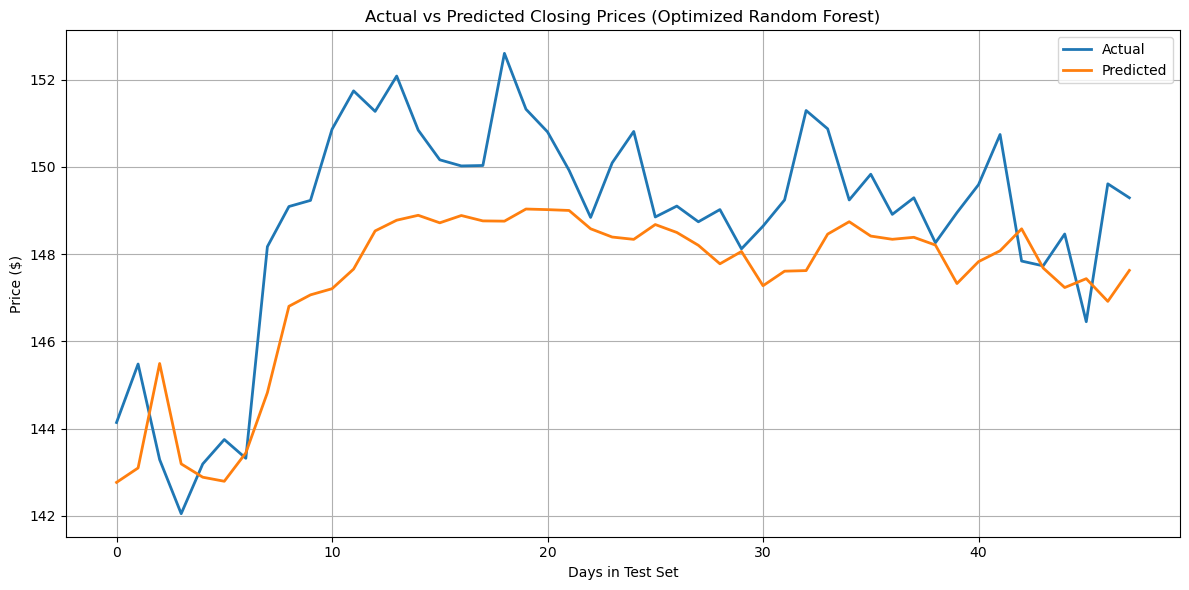

In [46]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Best Params:", grid_search.best_params_)
print("RMSE:", round(rmse, 2))
print("R² Score:", round(r2, 2))

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Closing Prices (Optimized Random Forest)")
plt.xlabel("Days in Test Set")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Let's apply Volatility and Rolling_STD_5 (used to measure how much a stock's price is fluctuating over a moving time window)

In [50]:
df['Volatility'] = (df['High'] - df['Low']) / df['Close']
df['Rolling_STD_5'] = df['Close'].rolling(window=5).std()

In [52]:
top_features = ['Open', 'High', 'Low', 'Close', 'Prev_Close', 'MA_3', 'MA_7', 'Lag_2', 'Lag_3','Volatility','Rolling_STD_5']

C:\Users\shris\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Best Params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
RMSE: 1.94
R² Score: 0.38


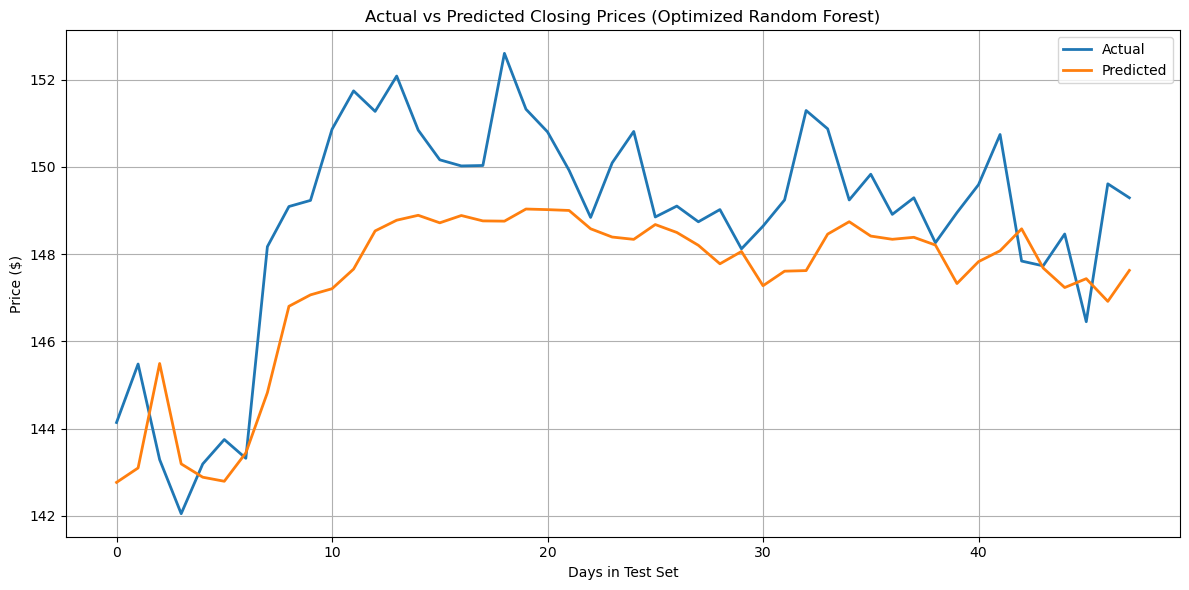

In [54]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Best Params:", grid_search.best_params_)
print("RMSE:", round(rmse, 2))
print("R² Score:", round(r2, 2))

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Closing Prices (Optimized Random Forest)")
plt.xlabel("Days in Test Set")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()